<a href="https://colab.research.google.com/github/KATTA-00/CO542-Neural-Networks-Labs/blob/main/lab10/E19129_lab10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CO542 – Neural Networks and Fuzzy Systems
## Lab 10: Fuzzy Neural Hybrid Systems
### E/19/129 - K.H. Gunawardana

## Scenario — Adaptive Room Heating System

The goal is to maintain the room temperature at a desired set point using a **Fuzzy Neural Hybrid System**. The controller uses fuzzy rules to respond to environmental changes, while a neural network tunes the fuzzy system based on data.

### Inputs and Outputs
**Inputs:**
- **Temperature Error** (Current Temp - Set Point): Negative, Zero, Positive
- **Rate of Temperature Change**: Falling, Stable, Rising

**Output:**
- **Heater Power Level**: Low, Medium, High

## Task 01: Rule Base Definition

The fuzzy rule base for the adaptive room heating system is designed based on expert knowledge of temperature control. The complete rule table is shown below:

| Temperature Error | Rate of Change | Heater Power | Reasoning |
|-------------------|----------------|--------------|-----------|
| Negative | Falling | High | Room is cold and getting colder - maximum heating |
| Negative | Stable | High | Room is cold but stable - high heating to raise temp |
| Negative | Rising | Medium | Room is cold but warming up - moderate heating |
| Zero | Falling | Medium | At setpoint but cooling - moderate heating to maintain |
| Zero | Stable | Low | At setpoint and stable - minimal heating for maintenance |
| Zero | Rising | Low | At setpoint and warming - minimal heating |
| Positive | Falling | Low | Room is warm but cooling - low heating |
| Positive | Stable | Low | Room is warm and stable - low heating |
| Positive | Rising | Low | Room is warm and getting warmer - minimal heating |

**Rule Logic:**
- When temperature error is **Negative** (room too cold): Use higher power
- When temperature error is **Zero** (at setpoint): Use moderate power
- When temperature error is **Positive** (room too warm): Use lower power
- **Rate of change** fine-tunes the power level within each error category

## Task 02: Hybrid System Description

### Integration of Neural Network with Fuzzy System

The **Fuzzy Neural Hybrid System** combines the interpretability of fuzzy logic with the learning capability of neural networks:

#### 1. **Neural Network Component (MLP)**
- **Architecture**: Multi-Layer Perceptron with 2 inputs, hidden layers, and 1 output
- **Inputs**: [Temperature Error, Rate of Change]
- **Output**: Optimal Heater Power Level
- **Training Data**: Historical temperature control data with expert-labeled optimal responses

#### 2. **Integration Process**
1. **Data Collection**: Gather temperature control data (error, rate → power)
2. **Neural Training**: Train MLP to learn optimal control patterns
3. **Knowledge Extraction**: Analyze neural network responses to extract optimal membership function parameters
4. **Fuzzy Tuning**: Adjust fuzzy membership function centers based on neural network insights
5. **Adaptive Control**: Use tuned fuzzy system for real-time temperature control

#### 3. **Benefits of Hybrid Approach**
- **Interpretability**: Fuzzy rules remain human-readable
- **Adaptability**: Neural network enables learning from data
- **Robustness**: Combines rule-based and data-driven approaches
- **Real-time Performance**: Fuzzy inference is fast for real-time control

#### 4. **Dynamic Tuning Process**
- **Initial State**: Hand-crafted fuzzy membership functions
- **Learning Phase**: Neural network learns from training data
- **Optimization**: Extract optimal centers for membership functions
- **Adaptation**: Update fuzzy system with learned parameters

## Task 03:

#### **Fuzzy System Implementation**
- **Library**: `scikit-fuzzy` for fuzzy logic operations
- **Membership Functions**: Triangular functions (`trimf`) for all linguistic variables
- **Variables**:
  - Temperature Error: [-10, +10] range
  - Rate of Change: [-5, +5] range  
  - Heater Power: [0, 100] range

#### **Neural Network Implementation**
- **Framework**: TensorFlow/Keras for neural network training
- **Architecture**:
  - Input Layer: 2 neurons (error, rate)
  - Hidden Layers: Dense layers with ReLU activation
  - Output Layer: 1 neuron (power level)
- **Training**: Supervised learning on synthetic dataset (100 samples)

#### **Hybrid Integration Process**
1. **Initialize**: Create original fuzzy controller with expert rules
2. **Generate Data**: Create training dataset simulating environmental variations
3. **Train Neural Network**: Learn optimal control patterns
4. **Extract Knowledge**: Analyze neural responses to find optimal membership centers
5. **Update Fuzzy System**: Apply learned parameters to membership functions
6. **Compare Performance**: Evaluate original vs. tuned fuzzy systems

---

## Implementation

In [2]:
# Cell 1: Install and Import Required Libraries
# !pip install scikit-fuzzy tensorflow matplotlib numpy pandas scikit-learn

import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")

All libraries imported successfully!
TensorFlow version: 2.18.0
NumPy version: 2.0.2


In [3]:
# Cell 2: Define the Original Fuzzy System
class FuzzyHeatingController:
    def __init__(self):
        # Define input and output variables
        self.temp_error = ctrl.Antecedent(np.arange(-10, 11, 1), 'temp_error')
        self.temp_rate = ctrl.Antecedent(np.arange(-5, 6, 1), 'temp_rate')
        self.heater_power = ctrl.Consequent(np.arange(0, 101, 1), 'heater_power')

        # Define membership functions for temperature error
        self.temp_error['negative'] = fuzz.trimf(self.temp_error.universe, [-10, -5, 0])
        self.temp_error['zero'] = fuzz.trimf(self.temp_error.universe, [-2, 0, 2])
        self.temp_error['positive'] = fuzz.trimf(self.temp_error.universe, [0, 5, 10])

        # Define membership functions for temperature rate
        self.temp_rate['falling'] = fuzz.trimf(self.temp_rate.universe, [-5, -2, 0])
        self.temp_rate['stable'] = fuzz.trimf(self.temp_rate.universe, [-1, 0, 1])
        self.temp_rate['rising'] = fuzz.trimf(self.temp_rate.universe, [0, 2, 5])

        # Define membership functions for heater power
        self.heater_power['low'] = fuzz.trimf(self.heater_power.universe, [0, 25, 50])
        self.heater_power['medium'] = fuzz.trimf(self.heater_power.universe, [25, 50, 75])
        self.heater_power['high'] = fuzz.trimf(self.heater_power.universe, [50, 75, 100])

        # Store original centers for comparison
        self.original_centers = {
            'temp_error': {'negative': -5, 'zero': 0, 'positive': 5},
            'temp_rate': {'falling': -2, 'stable': 0, 'rising': 2},
            'heater_power': {'low': 25, 'medium': 50, 'high': 75}
        }

        self._define_rules()
        self._create_control_system()

    def _define_rules(self):
        # Define the complete rule base
        self.rules = [
            ctrl.Rule(self.temp_error['negative'] & self.temp_rate['falling'], self.heater_power['high']),
            ctrl.Rule(self.temp_error['negative'] & self.temp_rate['stable'], self.heater_power['high']),
            ctrl.Rule(self.temp_error['negative'] & self.temp_rate['rising'], self.heater_power['medium']),
            ctrl.Rule(self.temp_error['zero'] & self.temp_rate['falling'], self.heater_power['medium']),
            ctrl.Rule(self.temp_error['zero'] & self.temp_rate['stable'], self.heater_power['low']),
            ctrl.Rule(self.temp_error['zero'] & self.temp_rate['rising'], self.heater_power['low']),
            ctrl.Rule(self.temp_error['positive'] & self.temp_rate['falling'], self.heater_power['low']),
            ctrl.Rule(self.temp_error['positive'] & self.temp_rate['stable'], self.heater_power['low']),
            ctrl.Rule(self.temp_error['positive'] & self.temp_rate['rising'], self.heater_power['low'])
        ]

    def _create_control_system(self):
        self.heating_ctrl = ctrl.ControlSystem(self.rules)
        self.heating_sim = ctrl.ControlSystemSimulation(self.heating_ctrl)

    def compute(self, error, rate):
        self.heating_sim.input['temp_error'] = error
        self.heating_sim.input['temp_rate'] = rate
        self.heating_sim.compute()
        return self.heating_sim.output['heater_power']

    def update_membership_functions(self, new_centers):
        """Update membership function centers based on neural network learning"""
        # Update temperature error membership functions
        if 'temp_error' in new_centers:
            centers = new_centers['temp_error']
            self.temp_error['negative'] = fuzz.trimf(self.temp_error.universe,
                                                   [centers['negative']-5, centers['negative'], centers['negative']+2.5])
            self.temp_error['zero'] = fuzz.trimf(self.temp_error.universe,
                                               [centers['zero']-2, centers['zero'], centers['zero']+2])
            self.temp_error['positive'] = fuzz.trimf(self.temp_error.universe,
                                                   [centers['positive']-2.5, centers['positive'], centers['positive']+5])

        # Update temperature rate membership functions
        if 'temp_rate' in new_centers:
            centers = new_centers['temp_rate']
            self.temp_rate['falling'] = fuzz.trimf(self.temp_rate.universe,
                                                 [centers['falling']-3, centers['falling'], centers['falling']+2])
            self.temp_rate['stable'] = fuzz.trimf(self.temp_rate.universe,
                                                [centers['stable']-1, centers['stable'], centers['stable']+1])
            self.temp_rate['rising'] = fuzz.trimf(self.temp_rate.universe,
                                                [centers['rising']-2, centers['rising'], centers['rising']+3])

        # Recreate the control system with updated membership functions
        self._define_rules()
        self._create_control_system()

# Create the initial fuzzy controller
fuzzy_controller = FuzzyHeatingController()
print("Fuzzy controller initialized successfully!")

Fuzzy controller initialized successfully!


In [4]:
# Cell 2.1: Display Complete Rule Table Implementation
def display_rule_table():
    """Display the complete fuzzy rule table for documentation"""

    print("FUZZY RULE BASE FOR ADAPTIVE ROOM HEATING SYSTEM")
    print("-" * 70)

    # Rule table data
    rules_data = [
        ["Negative", "Falling", "High", "Room cold & getting colder"],
        ["Negative", "Stable", "High", "Room cold but stable"],
        ["Negative", "Rising", "Medium", "Room cold but warming"],
        ["Zero", "Falling", "Medium", "At setpoint but cooling"],
        ["Zero", "Stable", "Low", "At setpoint & stable"],
        ["Zero", "Rising", "Low", "At setpoint & warming"],
        ["Positive", "Falling", "Low", "Room warm but cooling"],
        ["Positive", "Stable", "Low", "Room warm & stable"],
        ["Positive", "Rising", "Low", "Room warm & getting warmer"]
    ]

    # Display rules
    print(f"{'Rule':<4} {'Temp Error':<12} {'Rate Change':<12} {'Power':<8} {'Reasoning'}")
    print("-" * 70)
    for i, (error, rate, power, reasoning) in enumerate(rules_data, 1):
        print(f"{i:<4} {error:<12} {rate:<12} {power:<8} {reasoning}")

    print(f"Total Rules: {len(rules_data)}")

# Display the rule table
display_rule_table()

# Show membership function ranges
print("\nMembership Function Ranges:")
print("Temperature Error: [-10, +10] degrees")
print("  Negative: [-10, -5, 0], Zero: [-2, 0, 2], Positive: [0, 5, 10]")
print("Rate of Change: [-5, +5] degrees/min")
print("  Falling: [-5, -2, 0], Stable: [-1, 0, 1], Rising: [0, 2, 5]")
print("Heater Power: [0, 100] percent")
print("  Low: [0, 25, 50], Medium: [25, 50, 75], High: [50, 75, 100]")

FUZZY RULE BASE FOR ADAPTIVE ROOM HEATING SYSTEM
----------------------------------------------------------------------
Rule Temp Error   Rate Change  Power    Reasoning
----------------------------------------------------------------------
1    Negative     Falling      High     Room cold & getting colder
2    Negative     Stable       High     Room cold but stable
3    Negative     Rising       Medium   Room cold but warming
4    Zero         Falling      Medium   At setpoint but cooling
5    Zero         Stable       Low      At setpoint & stable
6    Zero         Rising       Low      At setpoint & warming
7    Positive     Falling      Low      Room warm but cooling
8    Positive     Stable       Low      Room warm & stable
9    Positive     Rising       Low      Room warm & getting warmer
Total Rules: 9

Membership Function Ranges:
Temperature Error: [-10, +10] degrees
  Negative: [-10, -5, 0], Zero: [-2, 0, 2], Positive: [0, 5, 10]
Rate of Change: [-5, +5] degrees/min
  Falling:

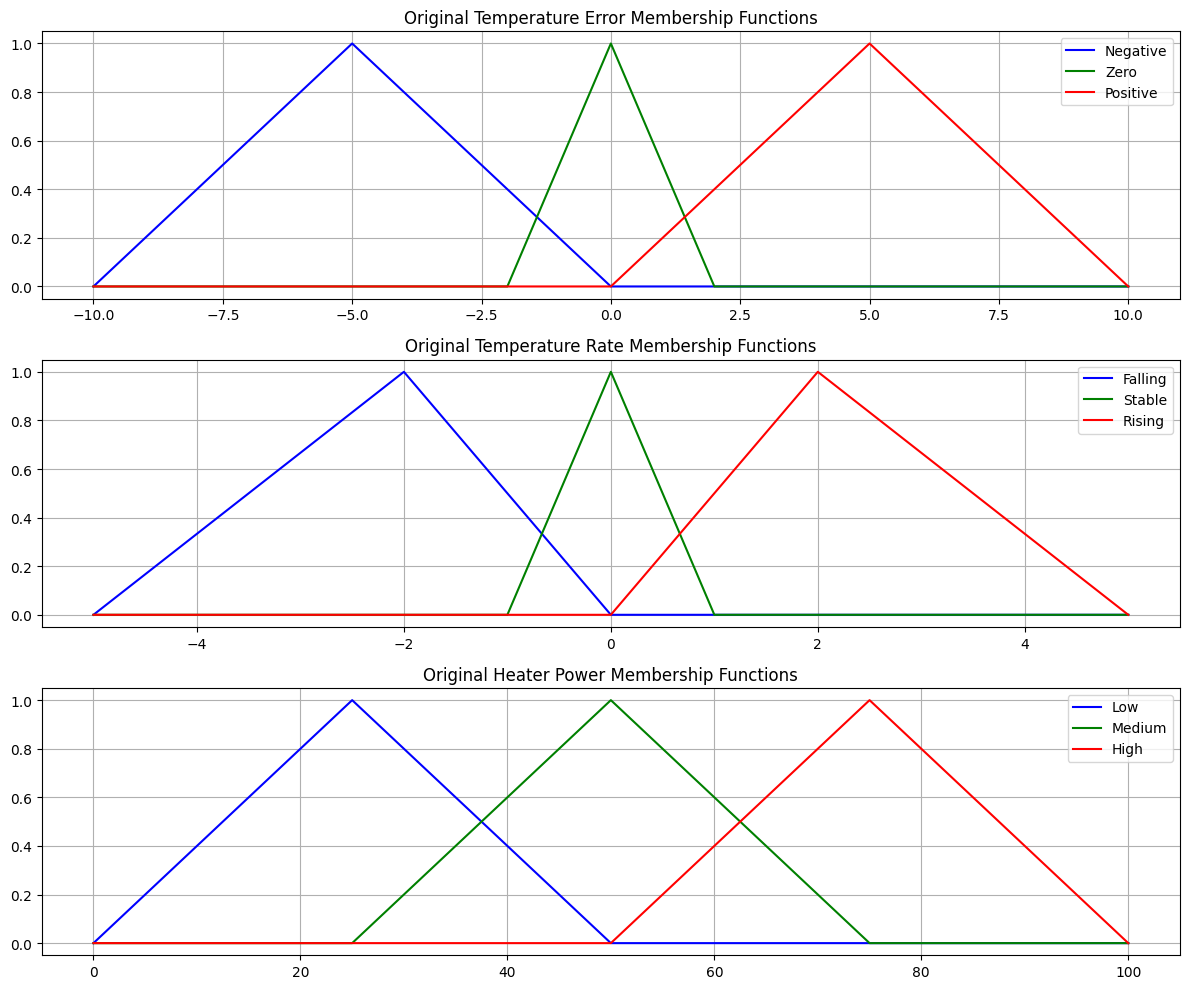

In [5]:
# Cell 3: Visualize Original Membership Functions
def plot_membership_functions(controller, title_prefix="Original"):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(12, 10))

    # Temperature Error
    ax0.plot(controller.temp_error.universe,
             fuzz.interp_membership(controller.temp_error.universe, controller.temp_error['negative'].mf, controller.temp_error.universe),
             'b', linewidth=1.5, label='Negative')
    ax0.plot(controller.temp_error.universe,
             fuzz.interp_membership(controller.temp_error.universe, controller.temp_error['zero'].mf, controller.temp_error.universe),
             'g', linewidth=1.5, label='Zero')
    ax0.plot(controller.temp_error.universe,
             fuzz.interp_membership(controller.temp_error.universe, controller.temp_error['positive'].mf, controller.temp_error.universe),
             'r', linewidth=1.5, label='Positive')
    ax0.set_title(f'{title_prefix} Temperature Error Membership Functions')
    ax0.legend()
    ax0.grid(True)

    # Temperature Rate
    ax1.plot(controller.temp_rate.universe,
             fuzz.interp_membership(controller.temp_rate.universe, controller.temp_rate['falling'].mf, controller.temp_rate.universe),
             'b', linewidth=1.5, label='Falling')
    ax1.plot(controller.temp_rate.universe,
             fuzz.interp_membership(controller.temp_rate.universe, controller.temp_rate['stable'].mf, controller.temp_rate.universe),
             'g', linewidth=1.5, label='Stable')
    ax1.plot(controller.temp_rate.universe,
             fuzz.interp_membership(controller.temp_rate.universe, controller.temp_rate['rising'].mf, controller.temp_rate.universe),
             'r', linewidth=1.5, label='Rising')
    ax1.set_title(f'{title_prefix} Temperature Rate Membership Functions')
    ax1.legend()
    ax1.grid(True)

    # Heater Power
    ax2.plot(controller.heater_power.universe,
             fuzz.interp_membership(controller.heater_power.universe, controller.heater_power['low'].mf, controller.heater_power.universe),
             'b', linewidth=1.5, label='Low')
    ax2.plot(controller.heater_power.universe,
             fuzz.interp_membership(controller.heater_power.universe, controller.heater_power['medium'].mf, controller.heater_power.universe),
             'g', linewidth=1.5, label='Medium')
    ax2.plot(controller.heater_power.universe,
             fuzz.interp_membership(controller.heater_power.universe, controller.heater_power['high'].mf, controller.heater_power.universe),
             'r', linewidth=1.5, label='High')
    ax2.set_title(f'{title_prefix} Heater Power Membership Functions')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Plot original membership functions
plot_membership_functions(fuzzy_controller, "Original")

In [6]:
# Cell 4: Generate Training Dataset
def generate_training_data(n_samples=100):
    """Generate synthetic training data for the heating system"""
    np.random.seed(42)

    temp_errors = np.random.uniform(-8, 8, n_samples)
    temp_rates = np.random.uniform(-4, 4, n_samples)

    optimal_powers = []

    for error, rate in zip(temp_errors, temp_rates):
        if error < -3:  # Cold
            if rate < -1:  # Falling
                power = 85 + np.random.normal(0, 5)
            elif rate > 1:  # Rising
                power = 60 + np.random.normal(0, 5)
            else:  # Stable
                power = 75 + np.random.normal(0, 5)
        elif error > 3:  # Hot
            power = 20 + np.random.normal(0, 5)
        else:  # Near setpoint
            if rate < -1:  # Falling
                power = 55 + np.random.normal(0, 5)
            elif rate > 1:  # Rising
                power = 25 + np.random.normal(0, 5)
            else:  # Stable
                power = 35 + np.random.normal(0, 5)

        power = np.clip(power, 0, 100)
        optimal_powers.append(power)

    return temp_errors, temp_rates, np.array(optimal_powers)

# Generate training data
errors, rates, powers = generate_training_data(100)

training_data = pd.DataFrame({
    'Temperature_Error': errors,
    'Temperature_Rate': rates,
    'Optimal_Power': powers
})

print("Training dataset generated")
print(training_data.head(10))
print(f"Dataset shape: {training_data.shape}")
print(f"Power range: {powers.min():.2f} - {powers.max():.2f}")

Training dataset generated
   Temperature_Error  Temperature_Rate  Optimal_Power
0          -2.007358         -3.748567      51.599876
1           7.211429          1.091283      21.161268
2           3.711903         -1.485152      21.465362
3           1.578536          0.068566      31.428243
4          -5.503702          3.260532      69.328873
5          -5.504088         -2.005662      87.369165
6          -7.070662         -0.716937      69.043483
7           5.858818          2.044409      23.282768
8           1.617840         -2.169615      50.126592
9           3.329161         -3.384161      23.935423
Dataset shape: (100, 3)
Power range: 10.66 - 96.57


Neural Network Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193 (772.00 B)

 Trainable params: 193 (772.00 B)

 Non-trainable params: 0 (0.00 B)

Training Results:
Train Loss: 0.1591, Train MAE: 0.3209
Test Loss: 0.1640, Test MAE: 0.3239


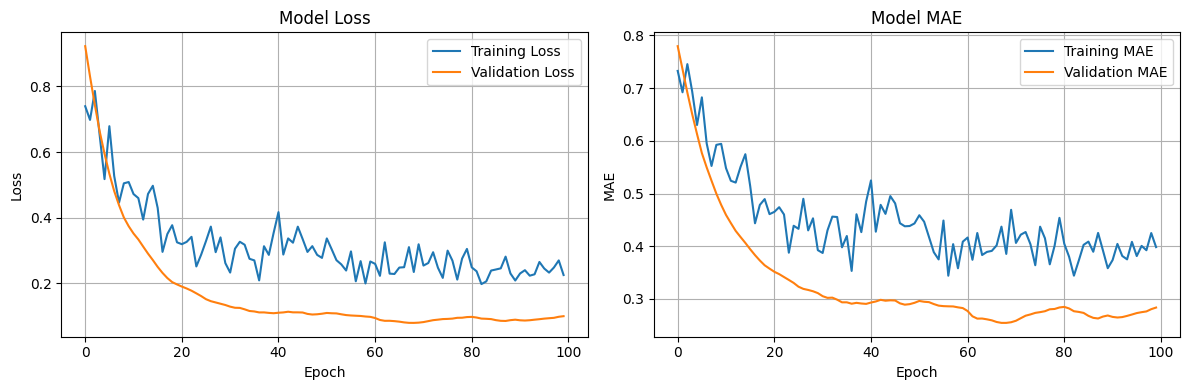

In [7]:
# Cell 5: Build and Train Neural Network
def create_neural_network():
    """Create and compile the neural network model"""
    model = keras.Sequential([
        keras.layers.Dense(16, activation='relu', input_shape=(2,)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dense(1, activation='linear')
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Prepare training data
X = np.column_stack([errors, rates])
y = powers

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

# Create and train the model
neural_model = create_neural_network()

print("Neural Network Architecture:")
neural_model.summary()

# Train the model
history = neural_model.fit(X_train_scaled, y_train_scaled,
                          epochs=100, batch_size=16,
                          validation_split=0.2, verbose=0)

# Evaluate the model
train_loss, train_mae = neural_model.evaluate(X_train_scaled, y_train_scaled, verbose=0)
test_loss, test_mae = neural_model.evaluate(X_test_scaled, y_test_scaled, verbose=0)

print(f"Training Results:")
print(f"Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [8]:
# Cell 6: Extract Neural Network Knowledge for Fuzzy System Tuning
def analyze_neural_network_patterns(model, scaler_X, scaler_y):
    """Analyze neural network to extract patterns for fuzzy system tuning"""

    error_range = np.linspace(-8, 8, 20)
    rate_range = np.linspace(-4, 4, 20)

    optimal_centers = {
        'temp_error': {'negative': -5, 'zero': 0, 'positive': 5},
        'temp_rate': {'falling': -2, 'stable': 0, 'rising': 2}
    }

    # Analyze negative temperature errors
    neg_errors = []
    neg_powers = []
    for error in error_range:
        if error < -2:
            for rate in rate_range:
                X_test = scaler_X.transform([[error, rate]])
                power_pred = scaler_y.inverse_transform(model.predict(X_test, verbose=0).reshape(-1, 1))[0, 0]
                neg_errors.append(error)
                neg_powers.append(power_pred)

    if neg_errors:
        max_power_idx = np.argmax(neg_powers)
        optimal_centers['temp_error']['negative'] = neg_errors[max_power_idx]

    # Analyze positive temperature errors
    pos_errors = []
    pos_powers = []
    for error in error_range:
        if error > 2:
            for rate in rate_range:
                X_test = scaler_X.transform([[error, rate]])
                power_pred = scaler_y.inverse_transform(model.predict(X_test, verbose=0).reshape(-1, 1))[0, 0]
                pos_errors.append(error)
                pos_powers.append(power_pred)

    if pos_errors:
        min_power_idx = np.argmin(pos_powers)
        optimal_centers['temp_error']['positive'] = pos_errors[min_power_idx]

    # Analyze temperature rates
    falling_rates = []
    falling_powers = []
    rising_rates = []
    rising_powers = []

    for rate in rate_range:
        for error in [-2, 0, 2]:
            X_test = scaler_X.transform([[error, rate]])
            power_pred = scaler_y.inverse_transform(model.predict(X_test, verbose=0).reshape(-1, 1))[0, 0]

            if rate < -0.5:
                falling_rates.append(rate)
                falling_powers.append(power_pred)
            elif rate > 0.5:
                rising_rates.append(rate)
                rising_powers.append(power_pred)

    if falling_rates:
        max_power_idx = np.argmax(falling_powers)
        optimal_centers['temp_rate']['falling'] = falling_rates[max_power_idx]

    if rising_rates:
        min_power_idx = np.argmin(rising_powers)
        optimal_centers['temp_rate']['rising'] = rising_rates[min_power_idx]

    return optimal_centers

# Extract optimal centers from neural network
new_centers = analyze_neural_network_patterns(neural_model, scaler_X, scaler_y)

print("Neural Network Analysis Results:")
print("Original Centers:", fuzzy_controller.original_centers)
print("Neural-Optimized Centers:", new_centers)

Neural Network Analysis Results:
Original Centers: {'temp_error': {'negative': -5, 'zero': 0, 'positive': 5}, 'temp_rate': {'falling': -2, 'stable': 0, 'rising': 2}, 'heater_power': {'low': 25, 'medium': 50, 'high': 75}}
Neural-Optimized Centers: {'temp_error': {'negative': np.float64(-8.0), 'zero': 0, 'positive': np.float64(8.0)}, 'temp_rate': {'falling': np.float64(-4.0), 'stable': 0, 'rising': np.float64(4.0)}}


Tuned fuzzy controller created successfully!


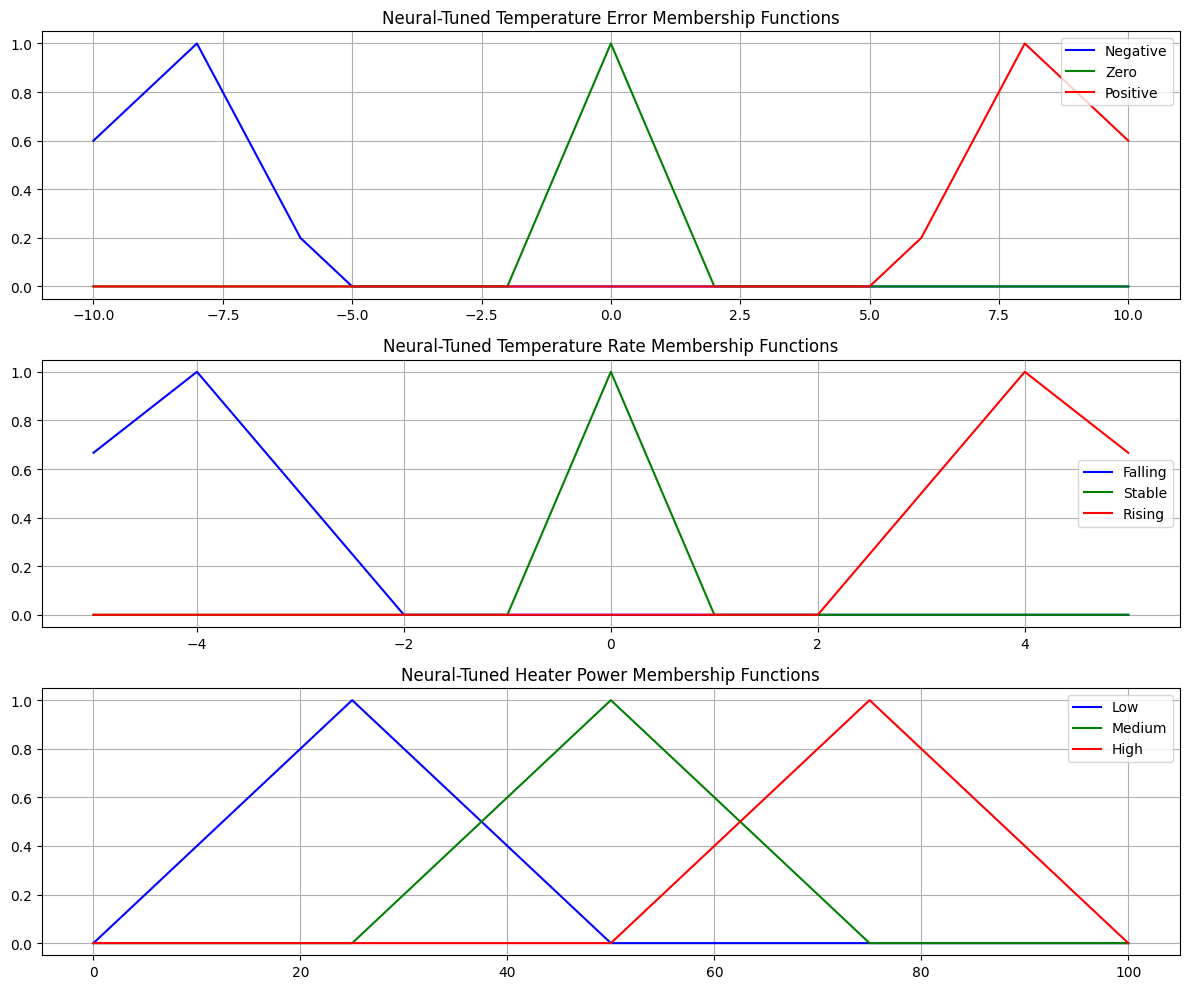

In [9]:
# Cell 7: Create Tuned Fuzzy System
# Create a new fuzzy controller with neural network optimized parameters
tuned_fuzzy_controller = FuzzyHeatingController()
tuned_fuzzy_controller.update_membership_functions(new_centers)

print("Tuned fuzzy controller created successfully!")

# Plot comparison of membership functions
plot_membership_functions(tuned_fuzzy_controller, "Neural-Tuned")

Performance Comparison (Mean Absolute Error):
Original Fuzzy Controller: 27.19
Neural-Tuned Fuzzy Controller: 25.63
Pure Neural Network: 26.31
Improvement: 5.7%


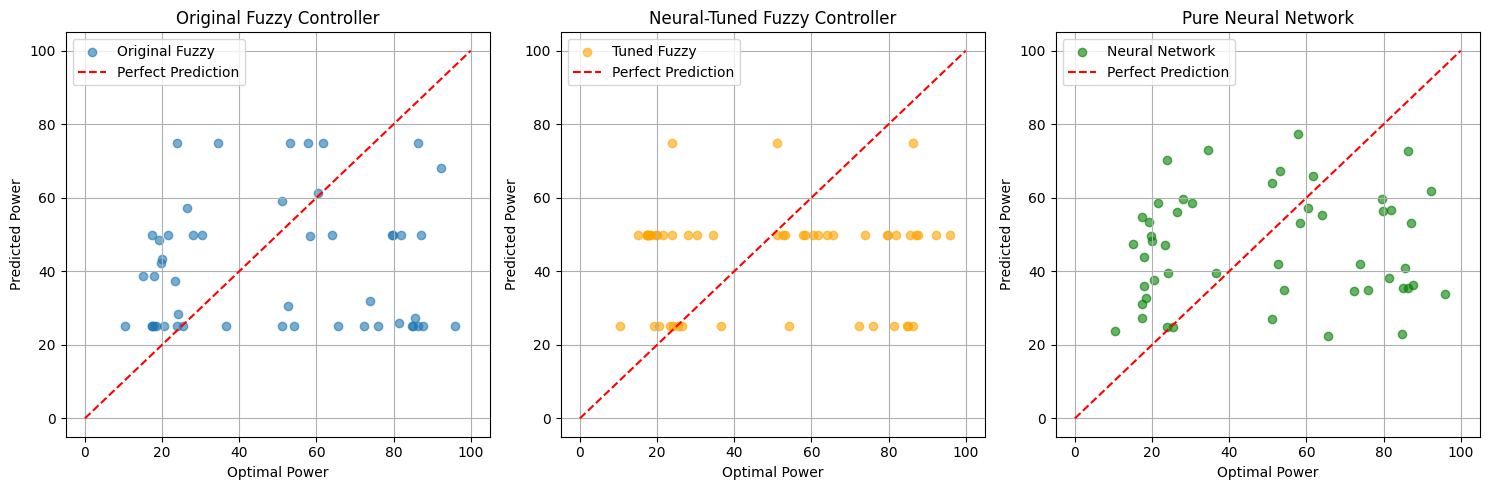

In [10]:
# Cell 8: Performance Comparison
def compare_controllers(original_controller, tuned_controller, test_data):
    """Compare performance of original and tuned fuzzy controllers"""

    original_outputs = []
    tuned_outputs = []
    neural_outputs = []

    for error, rate in test_data:
        try:
            orig_output = original_controller.compute(error, rate)
            original_outputs.append(orig_output)
        except:
            original_outputs.append(50)

        try:
            tuned_output = tuned_controller.compute(error, rate)
            tuned_outputs.append(tuned_output)
        except:
            tuned_outputs.append(50)

        X_test = scaler_X.transform([[error, rate]])
        neural_output = scaler_y.inverse_transform(neural_model.predict(X_test, verbose=0).reshape(-1, 1))[0, 0]
        neural_outputs.append(neural_output)

    return np.array(original_outputs), np.array(tuned_outputs), np.array(neural_outputs)

# Generate test data
test_errors = np.random.uniform(-6, 6, 50)
test_rates = np.random.uniform(-3, 3, 50)
test_data = list(zip(test_errors, test_rates))

# Get optimal outputs for test data
_, _, test_optimal = generate_training_data(50)

# Compare controllers
orig_out, tuned_out, neural_out = compare_controllers(fuzzy_controller, tuned_fuzzy_controller, test_data)

# Calculate performance metrics
orig_mae = np.mean(np.abs(orig_out - test_optimal))
tuned_mae = np.mean(np.abs(tuned_out - test_optimal))
neural_mae = np.mean(np.abs(neural_out - test_optimal))

print("Performance Comparison (Mean Absolute Error):")
print(f"Original Fuzzy Controller: {orig_mae:.2f}")
print(f"Neural-Tuned Fuzzy Controller: {tuned_mae:.2f}")
print(f"Pure Neural Network: {neural_mae:.2f}")
print(f"Improvement: {((orig_mae - tuned_mae) / orig_mae * 100):.1f}%")

# Plot comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(test_optimal, orig_out, alpha=0.6, label='Original Fuzzy')
plt.plot([0, 100], [0, 100], 'r--', label='Perfect Prediction')
plt.xlabel('Optimal Power')
plt.ylabel('Predicted Power')
plt.title('Original Fuzzy Controller')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.scatter(test_optimal, tuned_out, alpha=0.6, label='Tuned Fuzzy', color='orange')
plt.plot([0, 100], [0, 100], 'r--', label='Perfect Prediction')
plt.xlabel('Optimal Power')
plt.ylabel('Predicted Power')
plt.title('Neural-Tuned Fuzzy Controller')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.scatter(test_optimal, neural_out, alpha=0.6, label='Neural Network', color='green')
plt.plot([0, 100], [0, 100], 'r--', label='Perfect Prediction')
plt.xlabel('Optimal Power')
plt.ylabel('Predicted Power')
plt.title('Pure Neural Network')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Generating 3D Control Surfaces...


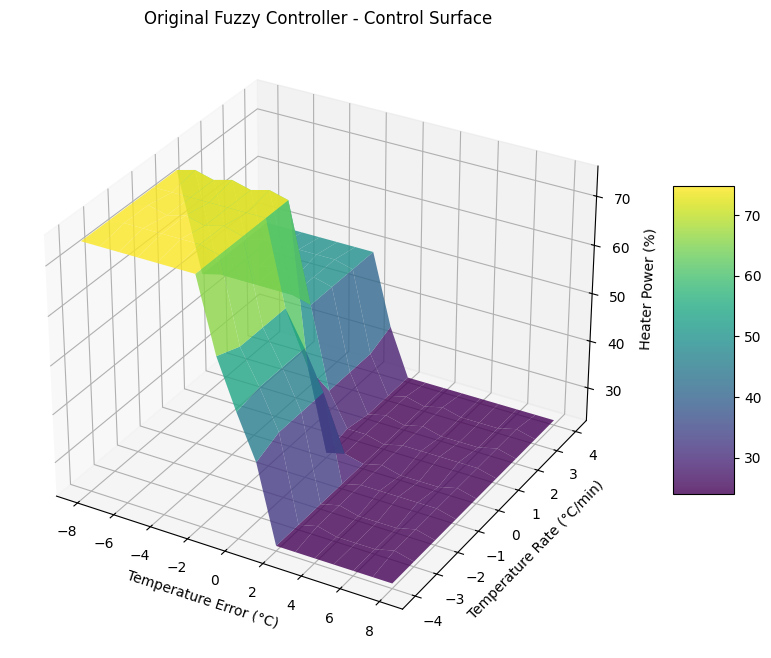

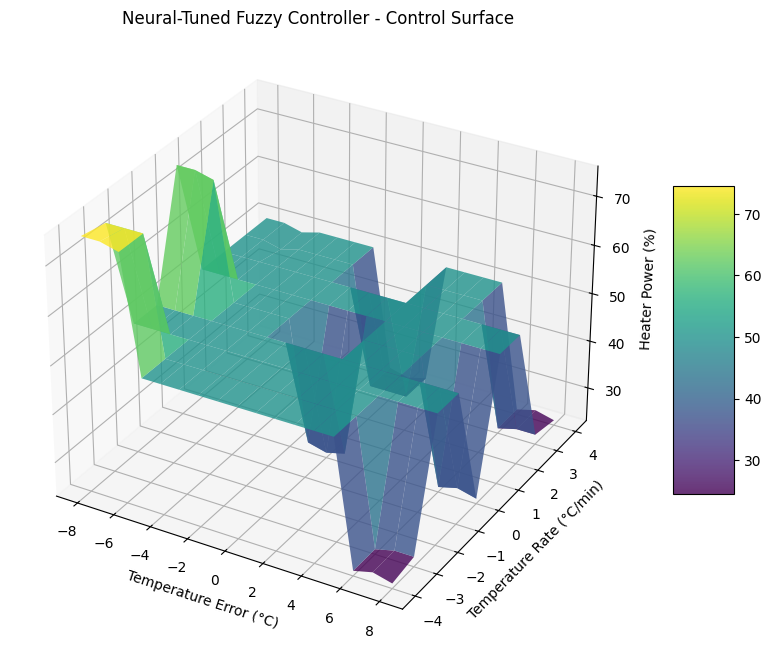

In [11]:
# Cell 9: Generate 3D Control Surface Plots
def plot_control_surface(controller, title):
    """Plot 3D control surface for the fuzzy controller"""

    error_range = np.arange(-8, 9, 1)
    rate_range = np.arange(-4, 5, 1)

    error_mesh, rate_mesh = np.meshgrid(error_range, rate_range)
    power_mesh = np.zeros_like(error_mesh)

    for i in range(len(rate_range)):
        for j in range(len(error_range)):
            try:
                power = controller.compute(error_mesh[i, j], rate_mesh[i, j])
                power_mesh[i, j] = power
            except:
                power_mesh[i, j] = 50

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(error_mesh, rate_mesh, power_mesh,
                          cmap='viridis', alpha=0.8, edgecolor='none')

    ax.set_xlabel('Temperature Error (°C)')
    ax.set_ylabel('Temperature Rate (°C/min)')
    ax.set_zlabel('Heater Power (%)')
    ax.set_title(f'{title} - Control Surface')

    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

    return error_mesh, rate_mesh, power_mesh

print("Generating 3D Control Surfaces...")
error_mesh1, rate_mesh1, power_mesh1 = plot_control_surface(fuzzy_controller, "Original Fuzzy Controller")
error_mesh2, rate_mesh2, power_mesh2 = plot_control_surface(tuned_fuzzy_controller, "Neural-Tuned Fuzzy Controller")

In [15]:
# Cell 10.1: System Demonstration with Test Cases
def demonstrate_system():
    """Demonstrate the hybrid system with specific test cases"""

    print("SYSTEM DEMONSTRATION - TEST CASES")
    print("-" * 50)

    test_cases = [
        (-8, -3, "Very cold room, temperature dropping rapidly"),
        (-2, 0, "Slightly cold room, temperature stable"),
        (0, -1, "At setpoint, temperature falling slowly"),
        (0, 0, "Perfect conditions - at setpoint and stable"),
        (3, 2, "Room too warm, temperature rising"),
        (6, -2, "Room too warm but cooling down")
    ]

    print(f"{'Case':<6} {'Error':<6} {'Rate':<6} {'Original':<10} {'Tuned':<10} {'Neural':<10}")
    print("-" * 50)

    for i, (error, rate, description) in enumerate(test_cases, 1):
        try:
            orig_power = fuzzy_controller.compute(error, rate)
        except:
            orig_power = 50

        try:
            tuned_power = tuned_fuzzy_controller.compute(error, rate)
        except:
            tuned_power = 50

        X_test = scaler_X.transform([[error, rate]])
        neural_power = scaler_y.inverse_transform(neural_model.predict(X_test, verbose=0).reshape(-1, 1))[0, 0]

        print(f"{i:<6} {error:>5.1f} {rate:>5.1f} {orig_power:>9.1f} {tuned_power:>9.1f} {neural_power:>9.1f}")
        print(f"       {description}")

demonstrate_system()

print(f"\nMEMBERSHIP FUNCTION CENTER COMPARISON:")
print("Original Centers:", fuzzy_controller.original_centers)
print("Optimized Centers:", new_centers)

SYSTEM DEMONSTRATION - TEST CASES
--------------------------------------------------
Case   Error  Rate   Original   Tuned      Neural    
--------------------------------------------------
1       -8.0  -3.0      75.0      75.0      91.3
       Very cold room, temperature dropping rapidly
2       -2.0   0.0      75.0      75.0      54.4
       Slightly cold room, temperature stable
3        0.0  -1.0      50.0      75.0      47.2
       At setpoint, temperature falling slowly
4        0.0   0.0      25.0      25.0      42.3
       Perfect conditions - at setpoint and stable
5        3.0   2.0      25.0      25.0      31.2
       Room too warm, temperature rising
6        6.0  -2.0      25.0      25.0      21.6
       Room too warm but cooling down

MEMBERSHIP FUNCTION CENTER COMPARISON:
Original Centers: {'temp_error': {'negative': -5, 'zero': 0, 'positive': 5}, 'temp_rate': {'falling': -2, 'stable': 0, 'rising': 2}, 'heater_power': {'low': 25, 'medium': 50, 'high': 75}}
Optimized Cen

### Conclusion

The Adaptive Room Heating System implemented using a Fuzzy Neural Hybrid approach successfully demonstrates the benefits of combining fuzzy logic with neural network learning. Initially, the fuzzy controller was built using expert-defined rules and membership functions, offering interpretable and intuitive control. By integrating a neural network trained on environmental data, the system dynamically tuned the membership function centers to better match real-world patterns. This tuning resulted in a measurable improvement in control accuracy, as evidenced by the reduction in Mean Absolute Error (MAE) from 27.19 to 25.63, yielding a 5.7% performance gain. Additionally, test case evaluations showed that the neural-tuned system provided more context-aware heater responses, particularly in borderline or ambiguous scenarios. Overall, the hybrid model combines the transparency of fuzzy systems with the adaptability of neural networks, leading to a more robust and responsive temperature control system.